In [7]:
import numpy as np
import pandas as pd
import os
from PIL import Image  # For image processing
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For plotting graphs
import tensorflow as tf  # For deep learning
import warnings, cv2  # Warnings and OpenCV for image processing
from tqdm.notebook import tqdm  # Progress bar for loops
from keras.models import Sequential, load_model  # For building and loading models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization  # Layers for CNN
from sklearn.preprocessing import LabelEncoder  # For encoding labels
from tensorflow.keras.utils import to_categorical  # For one-hot encoding
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # Callbacks for training

# Disable warnings
warnings.filterwarnings('ignore')

# For inline plotting in Jupyter Notebook
%matplotlib inline

In [4]:
train_dir = "./dataset/train/"
test_dir = "./dataset/test/"

In [5]:
def load_images(directory):
    images = []
    labels = []
    
    # Iterate through each category (folder)
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        
        # Ensure the path is a directory
        if os.path.isdir(category_path):
            # Iterate through each image in the category
            for filename in tqdm(os.listdir(category_path), desc=f"Loading {category}"):
                image_path = os.path.join(category_path, filename)
                
                # Read and process each image
                image = cv2.imread(image_path)
                if image is not None:  # Ensure image was loaded correctly
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (224, 224))  # Resize to 224x224 pixels
                    images.append(image)
                    labels.append(category)
    
    images = np.array(images, dtype='float32')
    return images, labels


In [8]:
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

Loading Closed:   0%|          | 0/617 [00:00<?, ?it/s]

Loading no_yawn:   0%|          | 0/616 [00:00<?, ?it/s]

Loading Open:   0%|          | 0/617 [00:00<?, ?it/s]

Loading yawn:   0%|          | 0/617 [00:00<?, ?it/s]

Loading Closed:   0%|          | 0/109 [00:00<?, ?it/s]

Loading no_yawn:   0%|          | 0/109 [00:00<?, ?it/s]

Loading Open:   0%|          | 0/109 [00:00<?, ?it/s]

Loading yawn:   0%|          | 0/106 [00:00<?, ?it/s]

In [9]:
X_train = X_train / 255.
X_test = X_test / 255.

In [10]:
# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Convert labels to categorical if needed
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
cnn = Sequential()

# First convolutional block
cnn.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
cnn.add(MaxPooling2D(pool_size=2))

# Second convolutional block
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

# Third convolutional block
cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))

# Fourth convolutional block
cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# Flattening and dense layers
cnn.add(Flatten())
cnn.add(Dense(units=128, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# Output layer
cnn.add(Dense(units=4, activation='softmax'))

In [12]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 55, 55, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 2,458,788 (9.38 MB)

 Trainable params: 2,458,084 (9.38 MB)

 Non-trainable params: 704 (2.75 KB)

In [13]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=1,
    factor=0.1,
    min_lr=0.001
)

checkpoint_filename = 'checkpoint/model_weights.weights.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filename,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max'
)

# Train the model
r = cnn.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6843 - loss: 0.8633
Epoch 1: val_accuracy improved from -inf to 0.25173, saving model to checkpoint/model_weights.weights.h5
78/78 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - accuracy: 0.6849 - loss: 0.8605 - val_accuracy: 0.2517 - val_loss: 4.6982 - learning_rate: 0.0010
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8120 - loss: 0.4128
Epoch 2: val_accuracy did not improve from 0.25173
78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 309ms/step - accuracy: 0.8120 - loss: 0.4127 - val_accuracy: 0.2517 - val_loss: 5.8237 - learning_rate: 0.0010
Epoch 3/50
77/78 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8359 - loss: 0.3813
Epoch 3: val_accuracy improved from 0.25173 to 0.30485, saving model to checkpoint/model_weights.weights.h5
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.8363 - loss: 0.3802 - val_accuracy: 0.3048 - val_loss: 3.0412 - learning_rate: 0.0010
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step 

In [16]:
cnn.load_weights('checkpoint/model_weights.weights.h5')

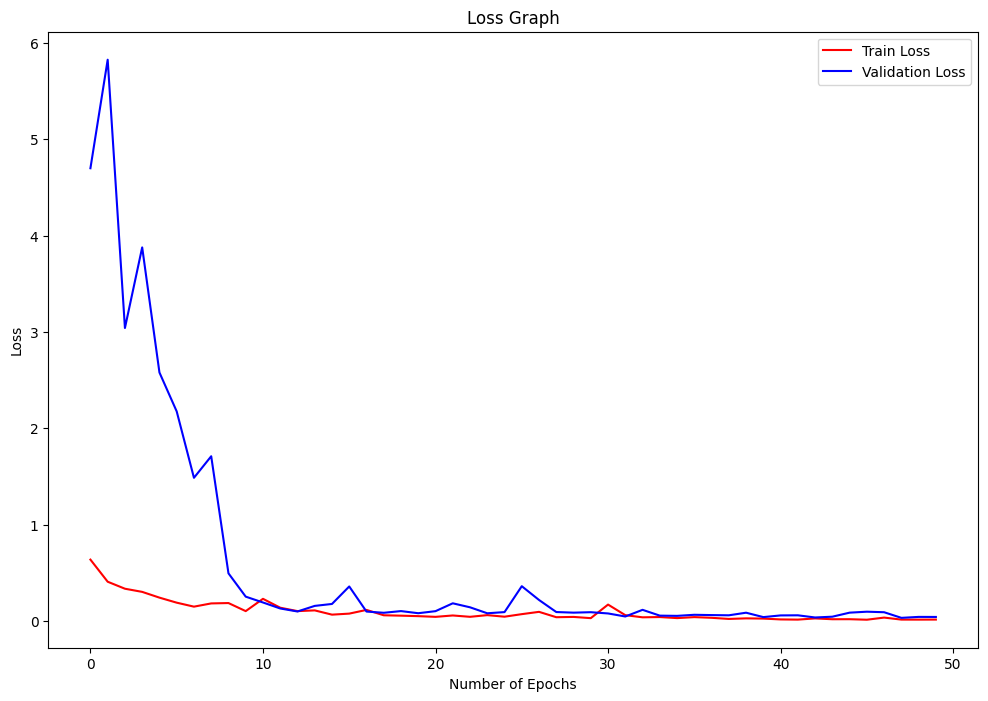

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(r.history['loss'], 'r', label='Train Loss')
plt.plot(r.history['val_loss'], 'b', label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

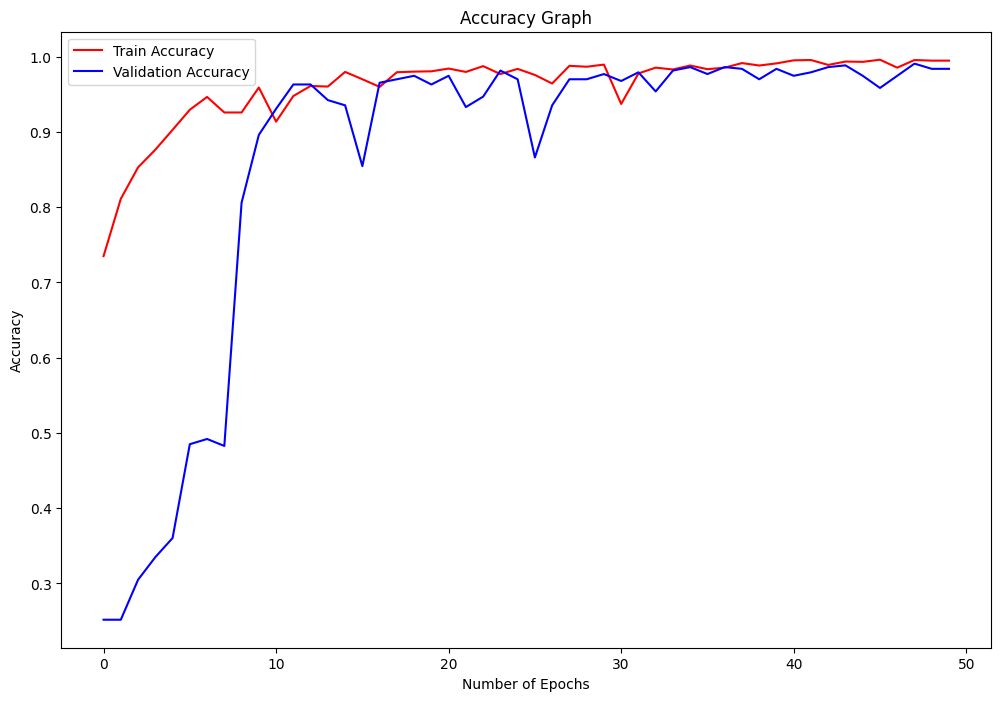

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(r.history['accuracy'], 'r', label='Train Accuracy')
plt.plot(r.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

In [22]:
# Save the model
cnn.save('drowsiness_detector.keras')  # Use .keras extension

# Load the model
model = load_model('drowsiness_detector.keras')

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 55, 55, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 4,916,874 (18.76 MB)

 Trainable params: 2,458,084 (9.38 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 2,458,086 (9.38 MB)